<a href="https://colab.research.google.com/github/n-bzy/iannwtf/blob/main/homework05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare dataset CIFAR-10

In [58]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

train_ds, val_ds = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

def preprocessing(data):
    """Preparing data sets for use in CNN"""
    data = data.map(lambda x,t : (tf.cast(x, tf.float32), t))
    data = data.map(lambda x,t : ((x/255.), t))
    data = data.map(lambda x,t : (x, tf.one_hot(t, depth=10)))

    data = data.cache()
    data = data.shuffle(1000)
    data = data.batch(256)
    data = data.prefetch(tf.data.AUTOTUNE)

    return data

# Test preprocessing and check for value and target shapes 
# (important for initializing of model with input values)
train_test = preprocessing(train_ds)

for x, t in train_test.take(1):
    print(x.shape, t.shape)

(256, 32, 32, 3) (256, 10)


# The CNN Model

In [63]:
class ResCNNBlock(tf.keras.layers.Layer):
    """Combine several conv2D-layers with use of bottleneck to a block"""
    def __init__(self, n_filters, b_filters, layers):
        """Initialize a first layer, bottleneck and Conv2D layers"""
        super().__init__()
        # First layer to get the input size match the output size
        self.deeper_layer = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=3, padding='same', activation='relu')
        # Use Bottleneck_in to reduce the depth of convolutional layers (b_filters << n_filters)
        self.bottleneck_in = tf.keras.layers.Conv2D(filters=b_filters, kernel_size=1, padding='same')
        self.layers = [tf.keras.layers.Conv2D(filters=b_filters, kernel_size=3, 
                        padding='same', activation='relu') for _ in range(layers)]
        # Use bottleneck_out to increase the depth back to the original size
        self.bottleneck_out = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=1, padding='same')

    def call(self, x):
        """Add the input to the output of the block for ResNet"""
        z = self.deeper_layer(x)
        c = self.bottleneck_in(z)
        for layer in self.layers:
            c = layer(c)
        c = self.bottleneck_out(c)
        # Add the (addapted) input to the output for Residual Learning
        x = z+c
        return x

class CNN(tf.keras.Model):
    """Combine several CNN blocks with pooling to a Convolutional Neuronal Network"""
    def __init__(self):
        """Initialize CNN blocks, pooling, optimizer, loss function and metrics"""
        super().__init__()

        self.block1 = ResCNNBlock(64, 16, 3)
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        # After pooling image size 16x16

        self.block2 = ResCNNBlock(128, 32, 4)
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        # After pooling image size 8x8

        # More layers lead to overfitting of training data

        self.block3 = ResCNNBlock(256, 64, 20)
        self.pool3 = tf.keras.layers.GlobalAvgPool2D()
        # After global pooling img size 1x1 for dense layer

        self.out = tf.keras.layers.Dense(10, activation='softmax')

        self.optimizer = tf.keras.optimizers.Adam()
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()
        self.metrics_list = [
            tf.keras.metrics.Mean(name='loss'),
            tf.keras.metrics.CategoricalAccuracy(name='accuracy')
            ]
    
    def call(self, x, training=False):
        """Pass the input trough the CNN"""
        x = self.block1(x)
        x = self.pool1(x)

        x = self.block2(x)
        x = self.pool2(x)

        x = self.block3(x)
        x = self.pool3(x) 

        y = self.out(x)
        return y

    def reset_metrics(self):
        """Function to reset every metric. Necessary for train_loop"""
        for metric in self.metrics_list:
            metric.reset_states()

    @tf.function
    def train(self, input):
        """Training step for CNN"""
        x,t = input

        with tf.GradientTape() as tape:
            output = self(x, training=True)
            loss = self.loss_function(t, output) + tf.reduce_sum(self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.metrics_list[0].update_state(values=loss)
        self.metrics_list[1].update_state(t, output)
        
        return {m.name:m.result() for m in self.metrics_list}
    
    @tf.function
    def test(self, input):
        """Testing step for CNN"""
        x,t = input
        output = self(x, training=False)
        loss = self.loss_function(t, output) + tf.reduce_sum(self.losses)

        self.metrics_list[0].update_state(values=loss)
        self.metrics_list[1].update_state(t, output)
        
        return {m.name:m.result() for m in self.metrics_list}

# Training the network

In [64]:
import tqdm

def training_loop(model, train_ds, val_ds, epochs):
    """Train and test the CNN for given epochs on given data"""

    train = preprocessing(train_ds)
    val = preprocessing(val_ds)

    # Save loss and accuracy as dictionaries in a list for visualization
    lists = []

    for n in range(epochs):
        print(f"Epoch {n}:")

        for data in tqdm.tqdm(train, position=0, leave=True):
            metrics = model.train(data)

        # Add metrics to list
        lists.append(metrics)
        print([f"{key}: {value.numpy()}" for (key,value) in metrics.items()])
        model.reset_metrics()

        for data in tqdm.tqdm(val, position=0, leave=True):
            metrics = model.test(data)

        # Add metrics to list
        lists.append(metrics)
        print([f"{key}: {value.numpy()}" for (key,value) in metrics.items()])
        model.reset_metrics()
        
    return lists

In [65]:
# Initiate model CNN
model = CNN()
model(tf.keras.Input((32,32,3)));

In [66]:
# IMPORTANT: Run ONLY with GPU Runtime
# Training loop
lists = training_loop(model, train_ds, val_ds, epochs=15)

Epoch 0:


100%|██████████| 196/196 [00:15<00:00, 12.46it/s]


['loss: 1.8148301839828491', 'accuracy: 0.3091199994087219']


100%|██████████| 40/40 [00:02<00:00, 15.56it/s]


['loss: 1.5804206132888794', 'accuracy: 0.41200000047683716']
Epoch 1:


100%|██████████| 196/196 [00:12<00:00, 15.22it/s]


['loss: 1.4509608745574951', 'accuracy: 0.46601998805999756']


100%|██████████| 40/40 [00:00<00:00, 47.40it/s]


['loss: 1.3722286224365234', 'accuracy: 0.49619999527931213']
Epoch 2:


100%|██████████| 196/196 [00:12<00:00, 15.18it/s]


['loss: 1.2672476768493652', 'accuracy: 0.5367799997329712']


100%|██████████| 40/40 [00:00<00:00, 47.32it/s]


['loss: 1.2194182872772217', 'accuracy: 0.550000011920929']
Epoch 3:


100%|██████████| 196/196 [00:12<00:00, 15.24it/s]


['loss: 1.127926230430603', 'accuracy: 0.593280017375946']


100%|██████████| 40/40 [00:00<00:00, 46.78it/s]


['loss: 1.0698506832122803', 'accuracy: 0.609499990940094']
Epoch 4:


100%|██████████| 196/196 [00:12<00:00, 15.47it/s]


['loss: 1.0273398160934448', 'accuracy: 0.6317800283432007']


100%|██████████| 40/40 [00:00<00:00, 47.85it/s]


['loss: 1.0389937162399292', 'accuracy: 0.6215000152587891']
Epoch 5:


100%|██████████| 196/196 [00:12<00:00, 15.53it/s]


['loss: 0.9442078471183777', 'accuracy: 0.6635800004005432']


100%|██████████| 40/40 [00:00<00:00, 47.70it/s]


['loss: 0.9140409231185913', 'accuracy: 0.6743999719619751']
Epoch 6:


100%|██████████| 196/196 [00:12<00:00, 15.45it/s]


['loss: 0.8750666379928589', 'accuracy: 0.6877599954605103']


100%|██████████| 40/40 [00:00<00:00, 47.58it/s]


['loss: 0.8802773356437683', 'accuracy: 0.6845999956130981']
Epoch 7:


100%|██████████| 196/196 [00:12<00:00, 15.46it/s]


['loss: 0.8165959119796753', 'accuracy: 0.7076600193977356']


100%|██████████| 40/40 [00:00<00:00, 47.61it/s]


['loss: 0.8737746477127075', 'accuracy: 0.6861000061035156']
Epoch 8:


100%|██████████| 196/196 [00:12<00:00, 15.41it/s]


['loss: 0.7642714977264404', 'accuracy: 0.7267799973487854']


100%|██████████| 40/40 [00:00<00:00, 47.61it/s]


['loss: 0.8293611407279968', 'accuracy: 0.7045999765396118']
Epoch 9:


100%|██████████| 196/196 [00:12<00:00, 15.43it/s]


['loss: 0.7291078567504883', 'accuracy: 0.7404199838638306']


100%|██████████| 40/40 [00:00<00:00, 47.62it/s]


['loss: 0.7952278852462769', 'accuracy: 0.718500018119812']
Epoch 10:


100%|██████████| 196/196 [00:12<00:00, 15.45it/s]


['loss: 0.6936420798301697', 'accuracy: 0.7524999976158142']


100%|██████████| 40/40 [00:00<00:00, 47.38it/s]


['loss: 0.7351962327957153', 'accuracy: 0.7396000027656555']
Epoch 11:


100%|██████████| 196/196 [00:12<00:00, 15.47it/s]


['loss: 0.659771203994751', 'accuracy: 0.766219973564148']


100%|██████████| 40/40 [00:00<00:00, 47.78it/s]


['loss: 0.7580637335777283', 'accuracy: 0.7324000000953674']
Epoch 12:


100%|██████████| 196/196 [00:12<00:00, 15.48it/s]


['loss: 0.6147303581237793', 'accuracy: 0.7820600271224976']


100%|██████████| 40/40 [00:00<00:00, 47.74it/s]


['loss: 0.7111777067184448', 'accuracy: 0.7531999945640564']
Epoch 13:


100%|██████████| 196/196 [00:12<00:00, 15.49it/s]


['loss: 0.5933763980865479', 'accuracy: 0.7875199913978577']


100%|██████████| 40/40 [00:00<00:00, 47.63it/s]


['loss: 0.7276114225387573', 'accuracy: 0.739799976348877']
Epoch 14:


100%|██████████| 196/196 [00:12<00:00, 15.47it/s]


['loss: 0.5537529587745667', 'accuracy: 0.8046200275421143']


100%|██████████| 40/40 [00:00<00:00, 47.70it/s]


['loss: 0.6478726863861084', 'accuracy: 0.7746000289916992']


# Visualization

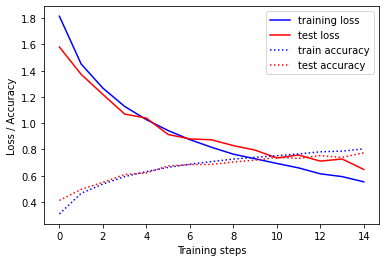

In [68]:
import matplotlib.pyplot as plt

def visualization(lists):
    """Visualizes accuracy and loss for training and test data """

    # Create lists for each visualized metric
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Split up the metrics to the corresponding lists
    for k in range(len(lists)):
        if k%2 == 1:
            test_loss.append(lists[k]['loss'].numpy())
            test_accuracy.append(lists[k]['accuracy'].numpy())
        else:
            train_loss.append(lists[k]['loss'].numpy())
            train_accuracy.append(lists[k]['accuracy'].numpy())

    # Plot the metrics
    plt.figure ()
    line1, = plt.plot(train_loss, "b-")
    line2, = plt.plot(test_loss, "r-")
    line3, = plt.plot(train_accuracy, "b:")
    line4, = plt.plot(test_accuracy, "r:")
    plt.xlabel("Training steps")
    plt.ylabel("Loss / Accuracy")
    plt.legend((line1 , line2 , line3 , line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show()

visualization(lists)